# Reverse suCOS scoring method

1. Break designed compound into bits at rotable bonds
2. SuCOS score these individual bits to all the fragments - a high sucCOS score would indicate that the shape/chem feature of the bit is best captured by that fragment
3. Capture best matching fragment IDs and bits
4. What to do if multiple best matches? See if same frag comes up with other bit matches. Select the frag that matched the most to other bits. Combine frags if tie. Beauty of using floats data types is that a tie is extremely unlikely! 
5. Output: Fragments with largest SuCOS score with bit
6. Overall score = mean of scores NEED more brainfarts here to think this through more!    



In [242]:
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit import RDConfig
import os
import numpy as np
import pandas as pd

def getBits(mol):
    '''

    Parameters
    ----------
    mol : rdkit mol object to be broken up into fragments by breaking 
    rotable bonds

    Returns
    -------
    mols : A list of rdkit mol objects

    '''
    # find the rotatable bonds
    bonds = mol.GetSubstructMatches(RotatableBondSmarts)
    
    bonds = [((x,y),(0,0)) for x,y in bonds]
    p = BRICS.BreakBRICSBonds(mol,bonds=bonds)
 
    mols = [mol for mol in Chem.GetMolFrags(p,asMols=True)]
    
    return mols

# Function to build feature maps and score two mol objects
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def getFeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    try: 
        featLists = []
        for m in [small_m, large_m]:
            rawFeats = fdef.GetFeaturesForMol(m)
            # filter that list down to only include the ones we're intereted in
            featLists.append([f for f in rawFeats if f.GetFamily() in keep])
        fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
        fms[0].scoreMode = score_mode
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score
    except ZeroDivisionError:
        return 0

In [243]:
docked_mol = Chem.MolFromMolFile('/home/warren/XChem_projects/COVID/xchem-sucos-select/3D_overlay_test/NIC-BIO-96e-2.sdf')

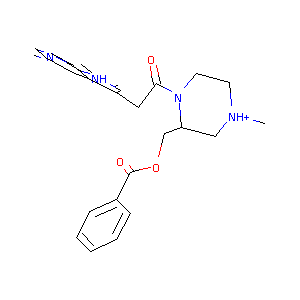

In [244]:
Draw.MolToImage(docked_mol)

In [245]:
docked_bits = getBits(docked_mol)

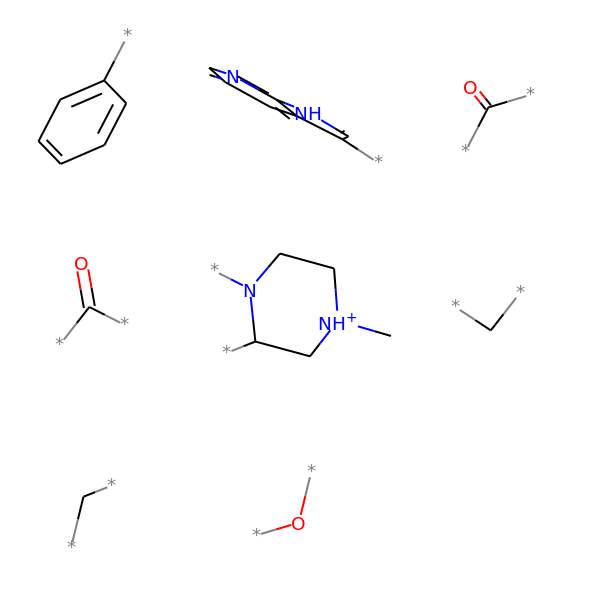

In [246]:
# What are the bits?
Draw.MolsToGridImage(docked_bits, molsPerRow=3)

In [247]:
# Read in fragment mols
frag_mol_folder = '/home/warren/XChem_projects/COVID/xchem-sucos-select/mol_files'
path  = frag_mol_folder + '/'
frag_mol_list = [Chem.MolFromMolFile((path + mol_file), sanitize=True) for mol_file in os.listdir(frag_mol_folder)]

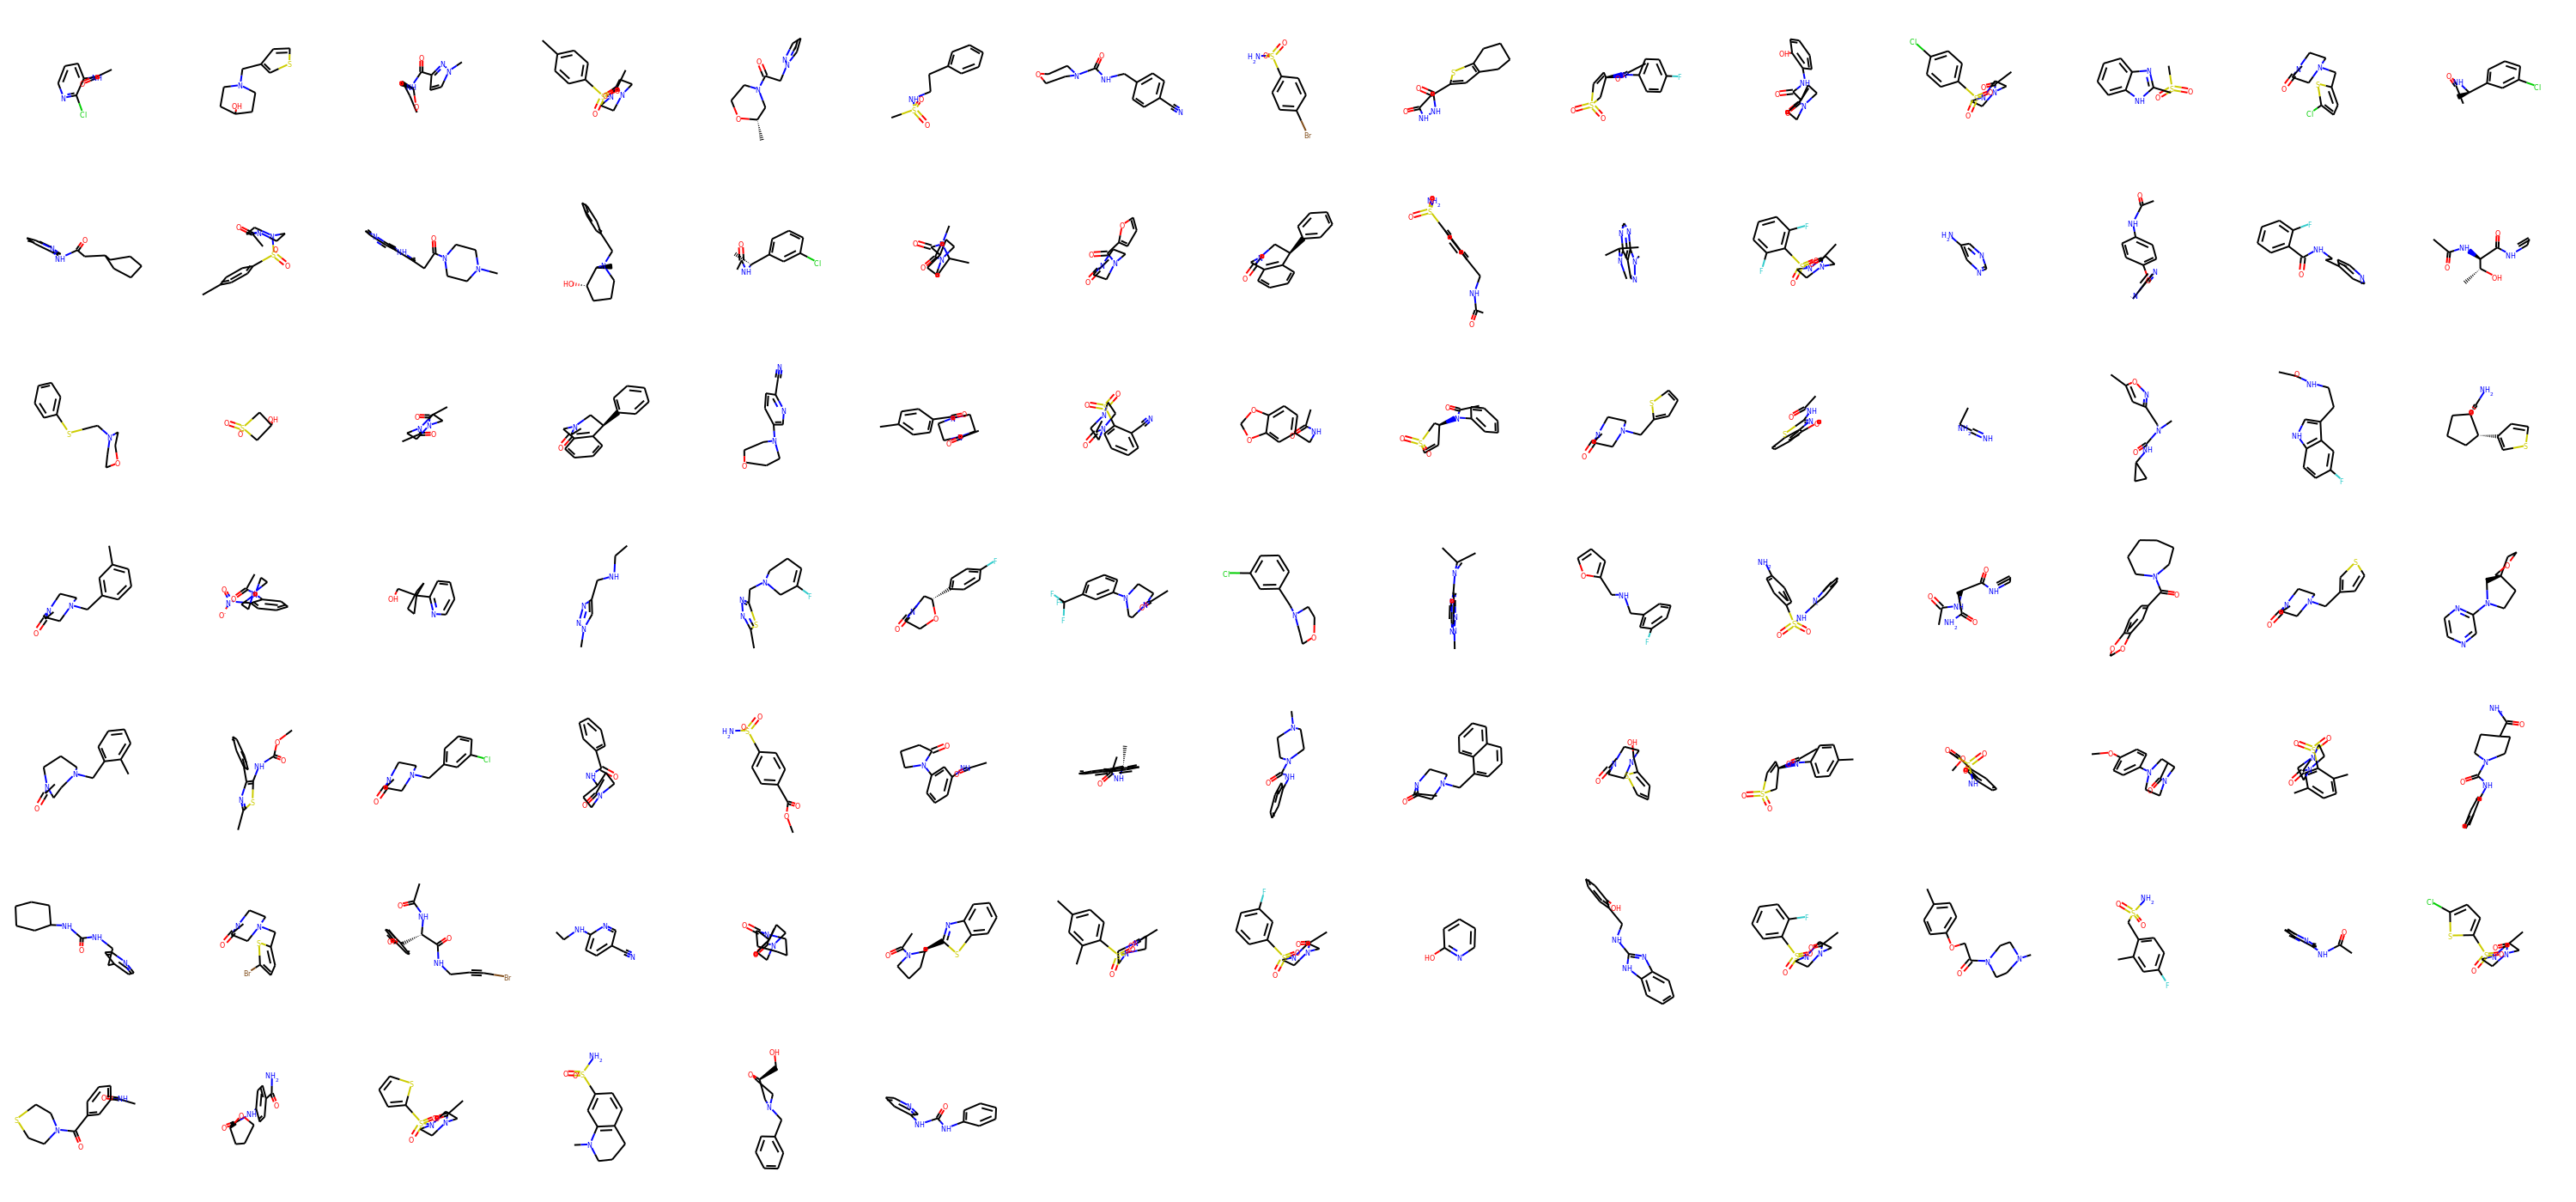

In [248]:
# What do the frags look like
Draw.MolsToGridImage(frag_mol_list, molsPerRow=15)

In [249]:
# Let's score docked bits to fragment mols
all_scores = []
for bit in docked_bits:
    scores = []
    for frag_mol in frag_mol_list:
            # NB reverse SuCOS scoring
            fm_score = getFeatureMapScore(bit, frag_mol)
            fm_score = np.clip(fm_score, 0, 1)             
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(frag_mol, docked_mol,
                                                             allowReordering=False)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            reverse_SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
            
            # Get some info and append to list
            frag_name = frag_mol.GetProp('_Name')
            
            scores.append((frag_name, reverse_SuCOS_score))
    all_scores.append(scores)
            

In [250]:
# Let's stay with bit 1 and see if we can do some filtering
# Cool so we have some scores! Can we filter these scores to yield fragemnt 
# with highest matching score and/or fragments with same score
bit_1_scores = all_scores[0]
bit_1_df = pd.DataFrame(data=bit_1_scores, columns = ['Fragment','Score'])
bit_1_df.head()

,Fragment,Score
0,x1478,0.146191
1,x0387,0.273373
2,x1187,0.000000
3,x0731,0.138134
4,x1132,0.000000


In [251]:
# Do we have a winner?
bit_1_df.max()

Fragment       x1493
Score       0.461586
dtype: object

In [252]:
# Ok but do really have a single winner? Let's check for multiple wins
 bit_1_df[bit_1_df['Score'] == bit_1_df['Score'].max()]

,Fragment,Score
17,x1093,0.461586


In [253]:
# Let's look at comparing all the bits and their scores looking for any
# multiple matches

list_dfs = [] 
for score in all_scores:
    df = pd.DataFrame(data=score, columns = ['Fragment','Score'])
    df = df[df['Score'] == df['Score'].max()]
    list_dfs.append(df)

final_df = pd.concat(list_dfs)
final_df

,Fragment,Score
17,x1093,0.461586
17,x1093,0.940764
17,x1093,0.461586
17,x1093,0.944999
17,x1093,0.898248
17,x1093,0.961586
5,x0072,0.751313
50,x0759,0.533059


In [254]:
# Double check for multiple macthes by comparing len df with number bits
len(final_df) == len(docked_bits)

True

In [255]:
# Ok so we have a single best match per bit with fragment x0434 matching the most with 
# two bits. What about an overall score though? Let's just take the mean for now but at least we
# can match scores with the bits

final_df.mean()

Score    0.744143
dtype: float64